<a href="https://colab.research.google.com/github/Falconwatch/cybersec_ht/blob/main/Statistical_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from tqdm import tqdm

In [2]:
cust_1 = pd.read_excel("cust_1.xlsx")
cust_2 = pd.read_excel("cust_2.xlsx")
examples = pd.read_excel("examples.xlsx")

In [3]:
cust_1 = cust_1.rename({"c1.country_code":"country_code"}, axis=1)
cust_2 = cust_2.rename({"c2.country_code":"country_code"}, axis=1)

In [4]:
countries = cust_1["country_code"].unique()

# Соберу все возможные комбинации

In [5]:
country_datas = list()
for country in countries:
  c1 = cust_1[cust_1["country_code"] == country]
  c2 = cust_2[cust_2["country_code"] == country]
  total = c1.reset_index(drop=True).merge(c2.reset_index(drop=True),
                                          on =["country_code"])
  country_datas.append(total)

In [6]:
all_data = pd.concat(country_datas)
all_data.shape

(5073577, 13)

In [7]:
examples = examples.rename({"c1.country_code":"country_code"}, axis=1).drop("c2.country_code", axis=1)
examples["dataset"] = "examples"

In [8]:
data = all_data.sample(100000).reset_index(drop=True)
data["dataset"] = "data"

In [9]:
full_data = pd.concat([examples, data])

In [10]:
full_data.head(4)

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,dataset
0,ACA467BD93827F6001DDD139E7AB4299,Atlantis Condo Resort Pattaya By ACC,Pattaya,TH,495/32 2floor Nongprue Banglamung,2.0,20150,845F505251CF1D83547D4669A44D17A4,Atlantis Condo Resort Pattaya by Kulisara,Jomtien Beach,"495/19, Moo 12, Jomtien Sai 2, Tambol Nongprue...",0.0,20250,examples
1,5BB207CBB33F3D099BCD979F86B3F54B,Chongqing Yangtze River Internatioanl Youth Ho...,Chongqing,CN,"No. 80, Changbin Road, Chao Tian Men Port",3.0,400010,9288C09CFB7714C3CAF57723C04BB6A4,Yangtze River International Youth Hostel,Chongqing,"No 80,Changbin Rd,Dock 11,ChaoTianMen,Yuzhong ...",2.0,400010,examples
2,97318B24C9C927AB8F50B13B44A706B5,Guangdong Hotel Zhuhai,Zhuhai,CN,"No. 1145 Yuehai Dong Road, Gongbei",4.0,519020,881982B8562A58BF3822C727B8A0C361,Guang Dong Hotel Zhuhai,Zhuhai,"No.1145, Yuehai East Road",4.0,519020,examples
3,03D43FDF92B0155912C46D8CEA46A874,Hampton Inn Nanuet - NY Hotel,Nanuet (NY),US,260 West Route 59,2.5,10954,F2A0C113B4F04002A6549BD940C54A95,Hampton Inn Nanuet,Nanuet,260 West Route 59,3.0,10954,examples


# Вычислю фичи сходства
Идеи:
- Улучшить вычисление расстояния для почтового кода - сверять слева направо

In [11]:
from difflib import SequenceMatcher
def similarity_ratio_func(df, field):
  def string_similarity(s1,s2):
    if pd.notna(s1) and pd.notna(s2):
      return SequenceMatcher(None, str(s1), str(s2)).ratio()
    return None

  name1 = "c1." + field
  name2 = "c2." + field
  name3 = field + "_similarity"
  df[name3] = df[[name1, name2]].apply(lambda x: string_similarity(x[name1], x[name2]), axis=1)

In [12]:
feature_fields = [c[3:] for c in cust_1.columns[1:] if "country" not in c]

In [13]:
for ff in tqdm(feature_fields):
  similarity_ratio_func(full_data, ff)

100%|██████████| 5/5 [00:46<00:00,  9.37s/it]


In [14]:
features = [c for c in full_data.columns if ("_similarity" in c) and ("_normed" not in c)]
ids = ["c1.key", "c2.key"]
features+ids

['hotel_name_similarity',
 'city_name_similarity',
 'hotel_address_similarity',
 'star_rating_similarity',
 'postal_code_similarity',
 'c1.key',
 'c2.key']

# Статистический подход

In [15]:
#Для дальнрейшей нормализации
means = full_data.loc[full_data["dataset"]=="examples", features].mean()
stds = full_data.loc[full_data["dataset"]=="examples", features].std()

In [16]:
#нормализуем
for f in features:
  full_data[f+"_normed"] = (full_data[f]-means[f])/stds[f]

In [17]:
features

['hotel_name_similarity',
 'city_name_similarity',
 'hotel_address_similarity',
 'star_rating_similarity',
 'postal_code_similarity']

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hotel_name_similarity_normed, dtype: object

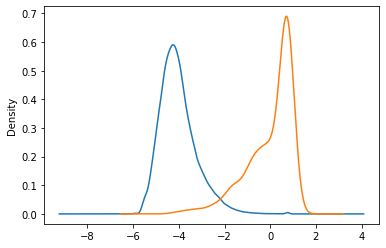

In [18]:
full_data.groupby('dataset')['hotel_name_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: city_name_similarity_normed, dtype: object

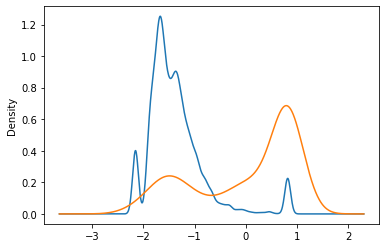

In [19]:
full_data.groupby('dataset')['city_name_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: hotel_address_similarity_normed, dtype: object

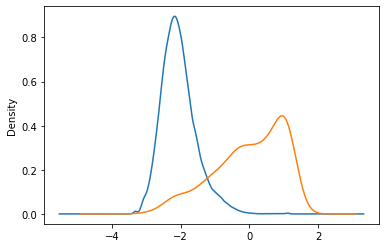

In [20]:
full_data.groupby('dataset')['hotel_address_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: star_rating_similarity_normed, dtype: object

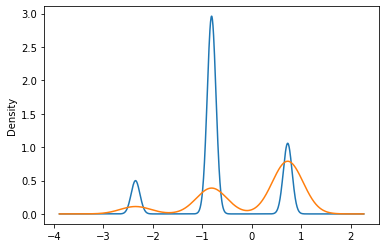

In [21]:
full_data.groupby('dataset')['star_rating_similarity_normed'].plot(kind='kde')

dataset
data        AxesSubplot(0.125,0.125;0.775x0.755)
examples    AxesSubplot(0.125,0.125;0.775x0.755)
Name: postal_code_similarity_normed, dtype: object

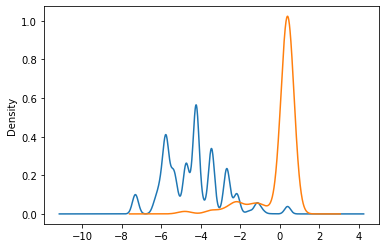

In [22]:
full_data.groupby('dataset')['postal_code_similarity_normed'].plot(kind='kde')

In [23]:
full_data.loc[(full_data["dataset"]=="examples") & (full_data["postal_code_similarity_normed"]<-2),
              ["c1.postal_code", "c2.postal_code"]]

,c1.postal_code,c2.postal_code
16,100,0
53,230012,230000
54,946,964
82,85251-3404,85251
86,71202-3909,71202
111,128,12711
128,184,165
142,34231-4832,34231
154,2020,50
194,2039,2041


#Квантили распределений

In [27]:
from scipy import stats

In [28]:
full_data.columns

Index(['c1.key', 'c1.hotel_name', 'c1.city_name', 'country_code',
       'c1.hotel_address', 'c1.star_rating', 'c1.postal_code', 'c2.key',
       'c2.hotel_name', 'c2.city_name', 'c2.hotel_address', 'c2.star_rating',
       'c2.postal_code', 'dataset', 'hotel_name_similarity',
       'city_name_similarity', 'hotel_address_similarity',
       'star_rating_similarity', 'postal_code_similarity',
       'hotel_name_similarity_normed', 'city_name_similarity_normed',
       'hotel_address_similarity_normed', 'star_rating_similarity_normed',
       'postal_code_similarity_normed'],
      dtype='object')

In [31]:
examples_tmp = full_data.loc[full_data["dataset"]=='examples']
for f in tqdm(features):
  full_data[f+"_normed_percentilte"] =\
    full_data[f+"_normed"].apply(lambda x: stats.percentileofscore(examples_tmp[f+"_normed"], x)/100)

100%|██████████| 5/5 [00:07<00:00,  1.50s/it]


In [33]:
full_data.sample(10000).to_excel("full_data_sample.xlsx")

## Множественная проверка гипотеза

In [34]:
from statsmodels.stats.multitest import multipletests

In [37]:
percentiles_fields = [c for c in full_data.columns if "_normed_percentilte" in c]

In [41]:
one_row = full_data.sample(1).iloc[0][percentiles_fields]
one_row

hotel_name_similarity_normed_percentilte            0.0
city_name_similarity_normed_percentilte        0.224928
hotel_address_similarity_normed_percentilte    0.040115
star_rating_similarity_normed_percentilte      0.237822
postal_code_similarity_normed_percentilte      0.008596
Name: 21591, dtype: object

In [44]:
full_data["multitest_result"] = full_data.apply(lambda x: multipletests(x[percentiles_fields].values), axis=1)

/usr/local/lib/python3.8/dist-packages/statsmodels/stats/multitest.py:160: RuntimeWarning: invalid value encountered in greater
  notreject = pvals > alphacSidak_all
/usr/local/lib/python3.8/dist-packages/statsmodels/stats/multitest.py:254: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


## Посмотрю глазами на отдельные кейсы

In [184]:
data_dist.shape

(100000, 6)

In [185]:
data.shape

(100000, 18)

In [187]:
(data_dist["hotel_name_similarity_ratio"]>0).mean()

0.00141

In [188]:
data

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,hotel_name_similarity_ratio,city_name_similarity_ratio,hotel_address_similarity_ratio,star_rating_similarity_ratio,postal_code_similarity_ratio
318839,80AEE7152500CAC10F05BD1A0AE3A791,Lynt Hotel Jakarta,Jakarta,ID,Jalan Cideng Timur No 35,3.0,10130,C2D930F1DE1FA9D785218A1E64B8F0E8,RedDoorz @ Tibubeneng Canggu,Canggu,Jl. Bantan Kangin Gg. Grandpa No. 3,2.0,80361,0.130435,0.153846,0.474576,0.666667,0.200000
764985,2FE2186DA00DFAA4BB4829CD7655EA0D,Best Western PLUS Madison Inn,Madison (FL),US,167 SE Bandit Street,2.0,32340-5916,AA2D58C37BDA289615D587309274D2EA,Best Western Roseville,Roseville,220 Harding Boulevard,2.0,95678,0.549020,0.095238,0.243902,1.000000,0.266667
22078,312E3E568C342818F387FB2989469B25,Gooding's Groves Olive Farm B&B,Franschhoek,ZA,"R45/Main Road, La Motte/Goederust, Franschhoek...",4.0,7690,15F23417B01AB7B1B598161A391C2865,Pongola Country Lodge,Pongola,14 Jan Mielie Street,0.0,3170,0.192308,0.111111,0.191304,0.666667,0.500000
869952,D4A634D64D52C558DF3F1AC57941DD38,Ploenlay,Krabi,TH,"199/42 Aonang Soi 8, Moo 3",2.0,81000,739E64478E5696A217DB017C1BA552FB,Sun Hill Hotel,Patong Beach,"245/2 Nanai Road, Kathu, Phuket",3.0,83150,0.363636,0.117647,0.350877,0.666667,0.600000
435424,84BCF7453EA1257D8FA507AD894F1249,Karon Hotel - Lajpat Nagar,New Delhi and NCR,IN,"61 Ring Road, Lajpat Nagar-3",3.5,110024,17B1E146C8EBE6A8E4BDB4D8B3687647,The Terraces,Chamba,"Kanatal, Chamba Mussorrie Highway, Tehri Garwala,",0.0,249145,0.105263,0.173913,0.259740,0.333333,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121450,71E7AAABDC8FD9334C2612AC54131612,7 Days Inn Jinan Da Ming Lake North Gate Branch,Jinan,CN,"No.5,Bei Guan North Road",2.0,NaN,4A8FE936563CEE5D88578923D9A7B028,Easy Inn Lianyue,Xiamen,No. 14 Lianyue Road,3.0,361000,0.349206,0.363636,0.511628,0.666667,0.000000
602260,BB6D3E937DAABDEBE7F048494EE0D8D6,Elara by Hilton Grand Vacations,Las Vegas (NV),US,80 East Harmon Drive,4.0,89109,7ED126119E65E99B07E83A73B5C0CB10,Quality Inn near Mountain Creek,Vernon,15 Route 94,2.0,7462,0.258065,0.200000,0.193548,0.666667,0.000000
48019,14298AA0D72EE61295A223586F8A8549,Acaill Accommodation,Adelaide,AU,"1/22 North Esplanade, Glenelg North",4.0,5045,77C561FED0FBEC92643EF18E304DE03C,Macleay Hotel,Sydney,"28 Macleay Street, Potts Point",3.5,2011,0.181818,0.285714,0.246154,0.333333,0.250000
868407,3CCD65979197E060C41A39A512800305,Hilton San Diego Airport Harbor Island Hotel,San Diego (CA),US,1960 Harbor Island Drive,3.0,92101,DCC70A9DE639EAA21961C64ECE3620CB,Econo Lodge Escanaba,Escanaba,921 North Lincoln Road,2.0,49829,0.250000,0.181818,0.347826,0.666667,0.400000


In [215]:
data[data_dist["hotel_name_similarity_ratio"]>-1.96]

,c1.key,c1.hotel_name,c1.city_name,country_code,c1.hotel_address,c1.star_rating,c1.postal_code,c2.key,c2.hotel_name,c2.city_name,c2.hotel_address,c2.star_rating,c2.postal_code,hotel_name_similarity_ratio,city_name_similarity_ratio,hotel_address_similarity_ratio,star_rating_similarity_ratio,postal_code_similarity_ratio
15,801BB2C9CD324535FA369F073B7C742E,Comfort Suites DFW Airport,Irving (TX),US,4700 W. John Carpenter Fwy.,3.0,75063,A0F9BC759FBE0CBC3FB2D046309EA67F,Comfort Suites Airport Nashville,Nashville,2521 Elm Hill Pike,2.0,37214,0.758621,0.200000,0.177778,0.666667,0.200000
18,77A7D83B81F1EE68A4F3E572F5424634,Hotel Maya Deluxe,Hyderabad,IN,"61/A, M.G.RoadRanigunj,Secunderabad.",1.0,500003,29D6E065185BEA2FA50493411A438443,Hotel Barbareek,Shillong,"Lewduh, Mawlonghat, Anjalee",2.0,793002,0.625000,0.000000,0.285714,0.666667,0.333333
120,6B029080375B069F45049F8AD027662E,Jinjiang Inn Beijing Wangfujing,Beijing,CN,"Dengshikou Street 75, Dongcheng District",2.0,NaN,C3A1BCFEC0BA1E078163BE653BFDF2B9,Jinjiang Inn Binzhou Huanghesan Road,Binzhou,"No. 498 Huanghesan Road, Binzhou, Shandong",3.0,256600,0.626866,0.428571,0.268293,0.666667,0.000000
135,DB5D05255FC54612A128D295208455A1,Villa Tiah,Bali,ID,"Jalan Kubu Anyar I No. 27, Kuta",3.0,80361,343DA985230DC487656C5972462B08F8,Villa Charlie,Kerobokan,Jl. Merta Agung,4.0,80361,0.608696,0.153846,0.217391,0.666667,1.000000
266,773EC92783AF52CB0B983C8DB4AF6085,Best Western Bastrop Pines Inn,Bastrop (TX),US,107 Hunters Crossing Boulevard,3.0,78602,C2614D5779D37454FE6F0251FA796DB7,Best Western Plus Cushing Inn & Suites,Cushing,508 East Main Street,0.0,74023,0.617647,0.105263,0.320000,0.666667,0.600000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99696,BC620E3E3946F72C414709EE056766D2,Kingsland Hotel,London,GB,Kingsbury Circle,3.0,NW9 9RR,1ED2D0B7F797B6205B25A9CC09146BAA,Barking Park Hotel,Barking,56-60 Tanner Street,0.0,IG11 8QF,0.606061,0.153846,0.285714,0.666667,0.133333
99698,5E4EE557D601D303B902447CD363165D,MARO Hotel,Hanoi,VN,64 Cau Go,3.0,100000,04EDA7DF46FA6F5F3F5C65D1B38F6E8E,Romance Hotel,Ho Chi Minh City,"67-69 Road No.5, Pham Hung, Binh Hung, Binh Chanh",1.0,NaN,0.608696,0.285714,0.137931,0.666667,0.000000
99710,3B5C0685B7BA73A4CFCBFB6A58E0705C,Legenda Boutique Hotel,Johor Bahru,MY,"No 7 & 9, Jalan Bestari 8/2, Taman Nusa Bestar...",2.0,79150,386CAC07A84CE7A75D7C8D551FD8AD5E,Ipoh Boutique Home,Ipoh,"20, Lebuh Tasek Timur 2, Kampung Bercham",0.0,31400,0.650000,0.266667,0.226804,0.666667,0.400000
99800,F64D8FCDC83C5EEA30B8E0542541F7CF,Lavy Hotel,Dalat,VN,"2B Lu Gia, Ward 9",3.0,NaN,21B73232797DFF519D384C251EB70618,Blue Heaven Hotel,Nha Trang,43 - 44 Nguyen Tat Thanh,2.0,NaN,0.592593,0.285714,0.292683,0.666667,1.000000
